# Chapter 7 - Advanced Feature Engineering

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Latent Semantic Analysis

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

def latent_semantic_analysis(docs):
  tfidf = TfidfVectorizer() # Using default parameters
  tfidf.fit(docs) # Creating dictionary
  vecs = tfidf.transform(docs) # Using dictionary to vectorize documents
  svd = TruncatedSVD(n_components=100) # Generating 100 top components
  svd.fit(vecs) # Creating SVD matrices
  return svd.transform(vecs) # Finally use LSA to vectorize documents

In [12]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
latent_semantic_analysis(newsgroups_train.data)

array([[ 0.24972705,  0.06942988,  0.01310897, ...,  0.03782795,
        -0.00157027,  0.00801295],
       [ 0.1399918 ,  0.07671455,  0.03975246, ...,  0.02621848,
         0.03578636, -0.0356997 ],
       [ 0.37184255,  0.041429  ,  0.06708912, ...,  0.03003491,
         0.00086582,  0.01227815],
       ..., 
       [ 0.18476811,  0.00611433,  0.08038825, ...,  0.00609275,
        -0.01109097,  0.00355132],
       [ 0.18795807,  0.0660674 , -0.04157325, ...,  0.00980154,
         0.0529207 , -0.01526676],
       [ 0.08231697,  0.09080506, -0.00372612, ..., -0.01004126,
        -0.01808032,  0.01173057]])

### Latent Dirichlet Analysis

In [14]:
from gensim.models.ldamodel import LdaModel

def lda_model(docs):
  # Build LDA model, setting the number of topics to extract
  return LdaModel(docs, num_topics=20)

def lda_vector(lda_model, doc):
  # Generate features for a new document
  return lda_model[doc]

In [17]:
from gensim.utils import mock_data
#gensim_docs = [d.split(" ") for d in newsgroups_train.data]
gensim_corpus = mock_data()
lda = lda_model(gensim_corpus)

### Histogram of Oriented Gradients 

See the full example in the Scikit-Image Gallery:

http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

In [25]:
from skimage import data, color, feature

image = color.rgb2gray(data.lena())
feature.hog(image, orientations=9, pixels_per_cell=(8,8),
      cells_per_block=(3,3), normalise=True, visualise=True)

(array([ 0.04526684,  0.0142712 ,  0.01551548, ...,  0.00192692,
         0.005256  ,  0.0027118 ]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.00272911, ...,  0.00113187,
          0.        ,  0.        ],
        [ 0.        ,  0.00026697,  0.        , ...,  0.        ,
          0.00048557,  0.        ],
        ..., 
        [ 0.        ,  0.00145732,  0.        , ...,  0.        ,
          0.00224509,  0.        ],
        [ 0.        ,  0.        ,  0.00322786, ...,  0.01282706,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]))

### Event data to time-series

(8000, 14000)

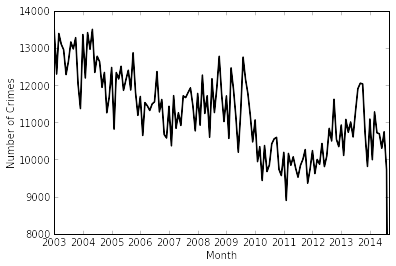

In [28]:
import pandas as pd
from datetime import datetime

df = pd.read_csv("data/sfpd_incident_all.csv")

df['Month'] = map(lambda x: datetime.strptime("/".join(x.split("/")[0::2]),"%m/%Y"),df['Date'])

# create classical time series
df_ts = df.groupby('Month').aggregate(len)["IncidntNum"]

# plot time series
plot(df_ts.index,df_ts.values,'-k',lw=2)
xlabel("Month")
ylabel("Number of Crimes")
ylim((8000, 14000))

### Windowed Statistics

In [30]:
# window = spring 2014
window1 = (datetime(2014,3,22),datetime(2014,6,21))

# find which data points fall within the window
idx_window = np.where(map(lambda x: x>=window1[0] and x<=window1[1], df_ts.index))[0]

# windowed mean and standard deviation
mean_window = np.mean(df_ts.values[idx_window])
std_window = np.std(df_ts.values[idx_window])

# windowed differences:
# window 2 = spring 2013
window2 = (datetime(2013,3,22),datetime(2013,6,21))

# find which data points fall within the window
idx_window2 = np.where(map(lambda x: x>=window2[0] and x<=window2[1], df_ts.index))[0]

# windowed differences: mean and standard deviation
mean_wdiff = mean_window - np.mean(df_ts.values[idx_window2])
std_wdiff = std_window - np.std(df_ts.values[idx_window2])


### Periodogram features

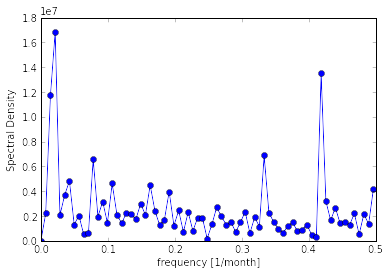

In [31]:
import scipy.signal

# compute the periodogram
f, psd = scipy.signal.periodogram(df_ts, detrend='linear')
plt.plot(f, psd,'-ob')
plt.xlabel('frequency [1/month]')
plt.ylabel('Spectral Density')
plt.show()

# Features:
# period of highest psd peak:
period_psd1 = 1./f[np.argmax(psd)] # = 47.0 months

# sum of spectral density higher than 1/12 months
sdens_gt_12m = np.sum(psd[f > 1./12])
# ratio of spectral density higher than to less than 1/12 months
sdens_ratio_12m = float(sdens_gt_12m) / np.sum(psd[f <= 1./12])
